## NeuroSHAP: Network-Aware SHAP for Neuroimaging Data
### Proof-of-Concept Implementation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import shap
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn.maskers import NiftiLabelsMasker
from nilearn.datasets import fetch_development_fmri

In [3]:
print("Loading Forrest Gump dataset...")
# Load Forrest Gump dataset
forrest_gump = fetch_development_fmri(n_subjects=155)
# Load Yeo 7-network atlas
yeo_atlas = datasets.fetch_atlas_yeo_2011()
atlas_filename = yeo_atlas['thick_7']
print("Extracting time series...")
# Create a masker to extract time series from each network
masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize=True,
    memory='nilearn_cache',
    verbose=0
)

# Extract time series for each subject
subject_data = []
subject_ids = []
subject_ages = []

# Process each subject - using direct indexing to ensure matching
for i, func_file in enumerate(forrest_gump.func):
    try:
        # Extract time series from the atlas regions
        time_series = masker.fit_transform(func_file)
        
        # Get age data - using direct iloc indexing which works with the dataset
        if i < len(forrest_gump.phenotypic):
            subject_age = forrest_gump.phenotypic.iloc[i]['Age']
            subject_data.append(time_series)
            subject_ids.append(i)
            subject_ages.append(subject_age)
            print(f"Processed subject {i+1}/{len(forrest_gump.func)}")
        else:
            print(f"Skipping subject {i+1} - no matching phenotypic data")
    except Exception as e:
        print(f"Error processing subject {i}: {e}")

print(f"Number of subject ages collected: {len(subject_ages)}")

# Convert ages to binary classification (younger vs. older)
subject_ages = np.array(subject_ages)
age_median = np.median(subject_ages)
age_labels = (subject_ages > age_median).astype(int)  # 0: younger, 1: older

# Convert to numpy arrays
subject_data = np.array(subject_data)

# Compute functional connectivity (correlation) for each subject
print("Computing functional connectivity...")
correlation_measure = ConnectivityMeasure(kind='correlation')
connectivity_matrices = correlation_measure.fit_transform(subject_data)
print(f"Connectivity matrices shape: {connectivity_matrices.shape}")

# Extract the upper triangle of each connectivity matrix as features
def extract_upper_triangle(matrix):
    num_networks = matrix.shape[0]
    indices = np.triu_indices(num_networks, k=1)
    return matrix[indices]

# Extract features with error checking
X = []
valid_indices = []
for i, matrix in enumerate(connectivity_matrices):
    features = extract_upper_triangle(matrix)
    if not np.isnan(features).any():  # Check if features contain NaN
        X.append(features)
        valid_indices.append(i)
    else:
        print(f"Subject {i}: Extracted features contain NaN values")

X = np.array(X)
valid_indices = np.array(valid_indices)

# Use valid indices for both X and y
y = age_labels[valid_indices]
print(f"Using {len(valid_indices)} subjects with valid features")

print(f"Data prepared: {X.shape[0]} subjects, {X.shape[1]} connectivity features")
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Final validation - make absolutely sure X and y match
assert X.shape[0] == y.shape[0], "Mismatch between X and y shapes"

Loading Forrest Gump dataset...
[fetch_development_fmri] Dataset found in /Users/henrikformoe/nilearn_data/development_fmri
[fetch_development_fmri] Dataset found in /Users/henrikformoe/nilearn_data/development_fmri/development_fmri
[fetch_development_fmri] Dataset found in /Users/henrikformoe/nilearn_data/development_fmri/development_fmri
[fetch_atlas_yeo_2011] Dataset found in /Users/henrikformoe/nilearn_data/yeo_2011
Extracting time series...


/var/folders/kb/t8njst5d1qg_hr3b0_jq9s2r0000gn/T/ipykernel_75099/3019450235.py:5: DeprecationWarning: From release >=0.13.0, instead of returning several atlas image accessible via different keys, this fetcher will return the atlas as a dictionary with a single atlas image, accessible through a 'maps' key. To suppress this warning, Please use the parameters 'n_networks' and 'thickness' to specify the exact atlas image you want.
  yeo_atlas = datasets.fetch_atlas_yeo_2011()


Processed subject 1/155
Processed subject 2/155
Processed subject 3/155
Processed subject 4/155
Processed subject 5/155
Processed subject 6/155
Processed subject 7/155
Processed subject 8/155
Processed subject 9/155
Processed subject 10/155
Processed subject 11/155
Processed subject 12/155
Processed subject 13/155
Processed subject 14/155
Processed subject 15/155
Processed subject 16/155
Processed subject 17/155
Processed subject 18/155
Processed subject 19/155
Processed subject 20/155
Processed subject 21/155
Processed subject 22/155
Processed subject 23/155
Processed subject 24/155
Processed subject 25/155
Processed subject 26/155
Processed subject 27/155
Processed subject 28/155
Processed subject 29/155
Processed subject 30/155
Processed subject 31/155
Processed subject 32/155
Processed subject 33/155
Processed subject 34/155
Processed subject 35/155
Processed subject 36/155
Processed subject 37/155
Processed subject 38/155
Processed subject 39/155
Processed subject 40/155
Processed

In [4]:
# 2. Model Training with Logistic Regression and Cross-Validation
# ------------------------------------------
print("Training Logistic Regression model with cross-validation...")

# Print shape information to debug
print(f"Original data shapes - X: {X.shape}, y: {y.shape}")

# Check for and remove any NaN values
nan_mask_X = np.isnan(X).any(axis=1)
if nan_mask_X.any():
    print(f"Found {np.sum(nan_mask_X)} rows with NaN values in X")
    X = X[~nan_mask_X]
    y = y[~nan_mask_X]

# Make sure X and y have the same number of samples
if len(X) != len(y):
    print(f"Mismatch in sample count: X has {len(X)} samples, y has {len(y)} samples")
    # Keep only the samples that have both X and y data
    min_samples = min(len(X), len(y))
    X = X[:min_samples]
    y = y[:min_samples]
    print(f"Adjusted to {min_samples} samples")

# Scale features (important for logistic regression)
print(f"Final data shapes - X: {X.shape}, y: {y.shape}")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use L2 regularization with reasonable C value
model = LogisticRegression(C=1.0, solver='liblinear', random_state=42)

# For cross-validation, adjust n_splits if sample size is small
n_splits = min(5, len(np.unique(y)))  # Ensure we don't have more splits than classes
print(f"Using {n_splits}-fold cross-validation")
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Run cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Train final model on all data
model.fit(X_scaled, y)

# Print results
print(f"Model accuracy on full dataset: {model.score(X_scaled, y):.2f}")
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Training Logistic Regression model with cross-validation...
Original data shapes - X: (155, 21), y: (155,)
Final data shapes - X: (155, 21), y: (155,)
Using 2-fold cross-validation
Model accuracy on full dataset: 0.73
Cross-validation accuracy: 0.67 ± 0.01


In [5]:
# 3. Standard SHAP Implementation
# ------------------------------
print("Computing standard SHAP values...")
# Create a prediction function that returns probabilities for class 1
def predict_proba_class1(X):
    return model.predict_proba(X)[:, 1]

# Create explainer with scaled data
explainer = shap.KernelExplainer(predict_proba_class1, X_scaled)
standard_shap_values = explainer.shap_values(X_scaled[0:1])

Using 155 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Computing standard SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# 4. Network-Aware SHAP Implementation
# -----------------------------------
print("Computing network-aware SHAP values...")

# Generate network-aware background data (using scaled data)
def network_aware_background_sampler(X, background_size=100):
    # Calculate the mean and covariance of the feature matrix
    mean_vec = np.mean(X, axis=0)
    cov_matrix = np.cov(X, rowvar=False)
    
    # Generate new samples using the covariance structure
    network_aware_background = np.random.multivariate_normal(
        mean=mean_vec, 
        cov=cov_matrix, 
        size=background_size
    )
    
    return network_aware_background

# Generate network-aware background data
network_background = network_aware_background_sampler(X_scaled)

# Create network-aware explainer
network_explainer = shap.KernelExplainer(
    predict_proba_class1,
    network_background
)

# Calculate network-aware SHAP values
network_shap_values = network_explainer.shap_values(X_scaled[0:1])

Computing network-aware SHAP values...


  0%|          | 0/1 [00:00<?, ?it/s]

Creating visualizations...
Visualization saved as 'neuroshap_logistic_comparison.png'

Key differences between methods:
VentralAttn: Increased importance by 0.039 with network-aware approach


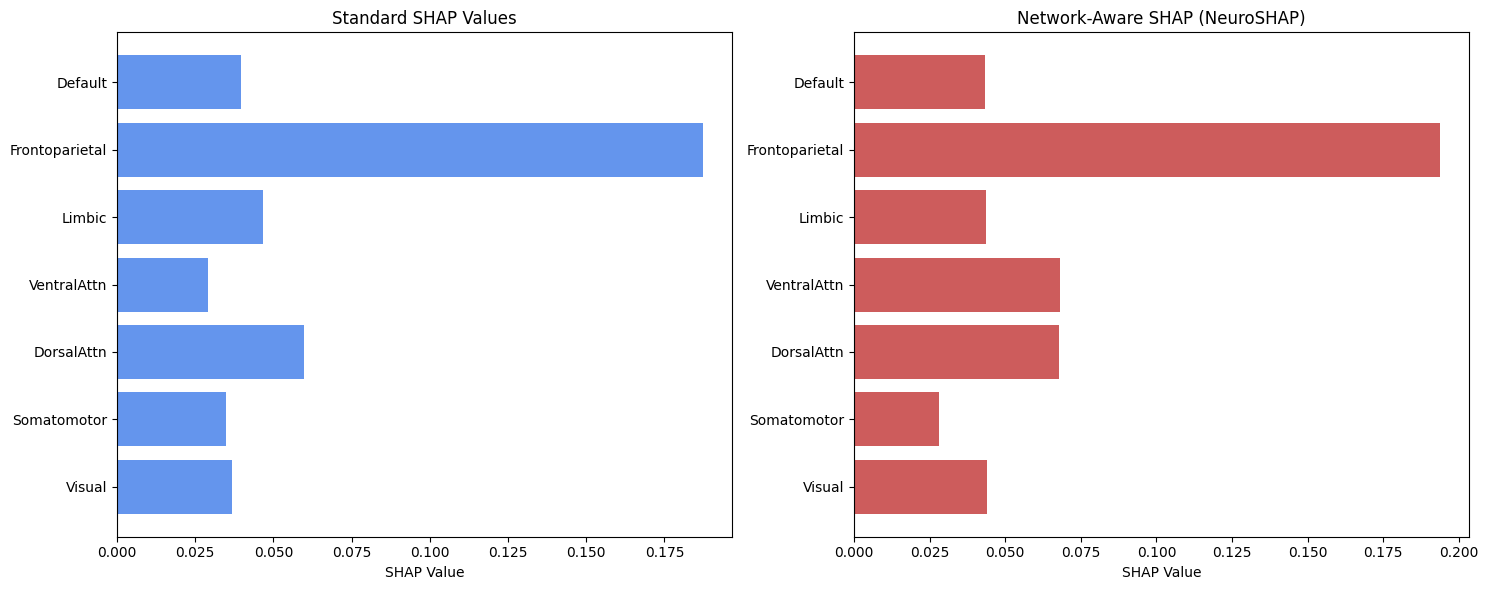

In [7]:
# 5. Visualization and Comparison
# ------------------------------
print("Creating visualizations...")

# Get network names
n_networks = 7
network_names = ['Visual', 'Somatomotor', 'DorsalAttn', 'VentralAttn', 
                'Limbic', 'Frontoparietal', 'Default']

# Initialize network-level SHAP values
standard_network_shap = np.zeros(n_networks)
network_aware_network_shap = np.zeros(n_networks)

# Map edge SHAP values back to networks
feature_idx = 0
for i in range(n_networks):
    for j in range(i+1, n_networks):
        # Add edge contribution to both connected networks
        standard_network_shap[i] += standard_shap_values[0][feature_idx] / 2
        standard_network_shap[j] += standard_shap_values[0][feature_idx] / 2
        
        network_aware_network_shap[i] += network_shap_values[0][feature_idx] / 2
        network_aware_network_shap[j] += network_shap_values[0][feature_idx] / 2
        
        feature_idx += 1

# Create side-by-side visualization
plt.figure(figsize=(15, 6))

# Standard SHAP visualization
plt.subplot(1, 2, 1)
plt.barh(network_names, standard_network_shap, color='cornflowerblue')
plt.title('Standard SHAP Values')
plt.xlabel('SHAP Value')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Network-aware SHAP visualization
plt.subplot(1, 2, 2)
plt.barh(network_names, network_aware_network_shap, color='indianred')
plt.title('Network-Aware SHAP (NeuroSHAP)')
plt.xlabel('SHAP Value')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig('neuroshap_logistic_comparison.png')
print("Visualization saved as 'neuroshap_logistic_comparison.png'")

# Display key findings
print("\nKey differences between methods:")
for i, network in enumerate(network_names):
    diff = network_aware_network_shap[i] - standard_network_shap[i]
    if abs(diff) > 0.01:
        print(f"{network}: {'Increased' if diff > 0 else 'Decreased'} importance " +
              f"by {abs(diff):.3f} with network-aware approach")

Visualizing network connectivity structure...
Creating enhanced network visualizations...
Testing stability of network-aware SHAP...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

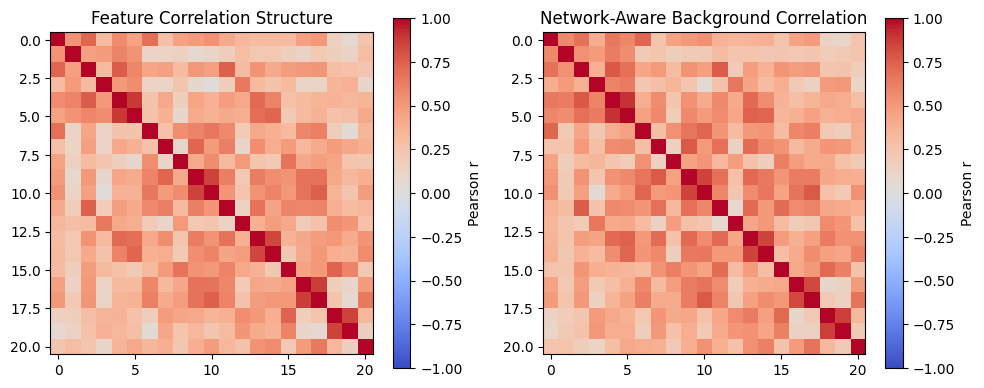

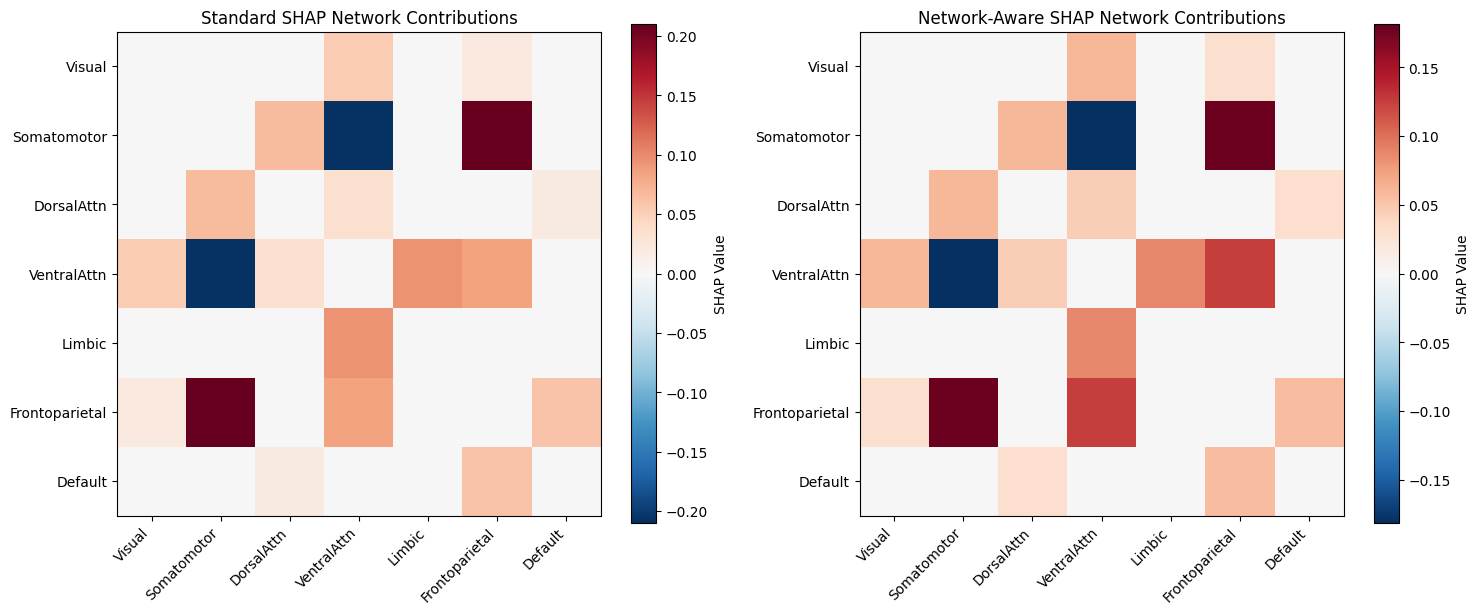

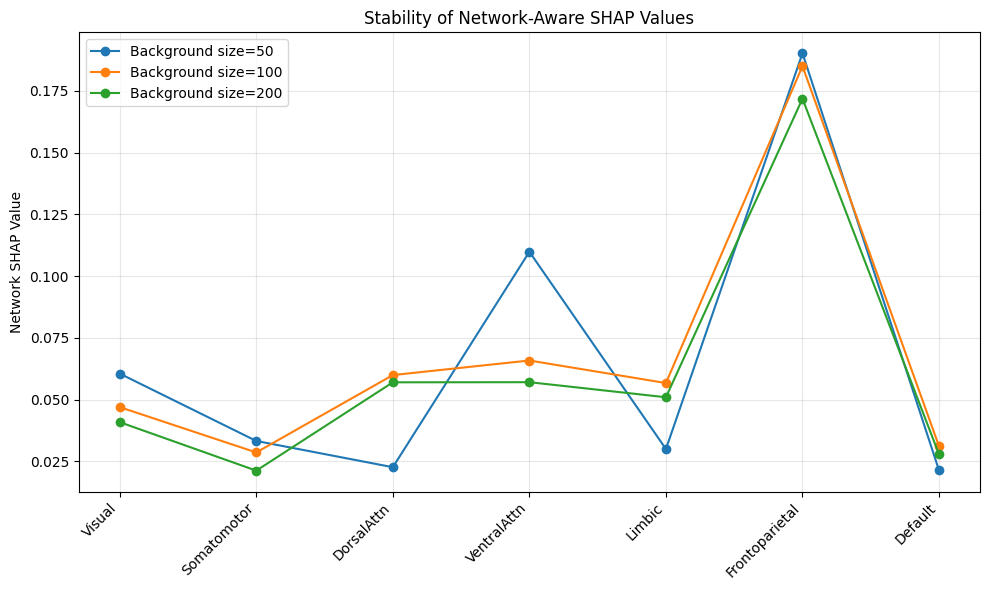

In [8]:
# Enhanced Network-Aware SHAP Implementation
# ------------------------------------------

# 1. Add visualization of correlation structure
print("Visualizing network connectivity structure...")
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.corrcoef(X_scaled.T), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.title('Feature Correlation Structure')

plt.subplot(1, 2, 2)
plt.imshow(np.corrcoef(network_background.T), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson r')
plt.title('Network-Aware Background Correlation')
plt.tight_layout()
plt.savefig('network_structure_comparison.png')

# 2. Improved network-level SHAP visualization
print("Creating enhanced network visualizations...")

# Function to map features to network pairs
def get_network_pair_indices(n_networks):
    pairs = []
    idx = 0
    for i in range(n_networks):
        for j in range(i+1, n_networks):
            pairs.append((idx, (i, j)))
            idx += 1
    return pairs

# Get network pair mapping
network_pairs = get_network_pair_indices(n_networks)

# Create a network x network SHAP matrix visualization
def create_network_matrix(shap_values, n_networks, network_pairs):
    matrix = np.zeros((n_networks, n_networks))
    for idx, (i, j) in network_pairs:
        matrix[i, j] = shap_values[0][idx]
        matrix[j, i] = shap_values[0][idx]  # Mirror for visualization
    return matrix

# Visualize SHAP values as connectivity matrices
plt.figure(figsize=(15, 6))

# Standard SHAP matrix
std_matrix = create_network_matrix(standard_shap_values, n_networks, network_pairs)
plt.subplot(1, 2, 1)
im = plt.imshow(std_matrix, cmap='RdBu_r', vmin=-np.max(abs(std_matrix)), vmax=np.max(abs(std_matrix)))
plt.colorbar(im, label='SHAP Value')
plt.title('Standard SHAP Network Contributions')
plt.xticks(range(n_networks), network_names, rotation=45, ha='right')
plt.yticks(range(n_networks), network_names)

# Network-aware SHAP matrix
net_matrix = create_network_matrix(network_shap_values, n_networks, network_pairs)
plt.subplot(1, 2, 2)
im = plt.imshow(net_matrix, cmap='RdBu_r', vmin=-np.max(abs(net_matrix)), vmax=np.max(abs(net_matrix)))
plt.colorbar(im, label='SHAP Value')
plt.title('Network-Aware SHAP Network Contributions')
plt.xticks(range(n_networks), network_names, rotation=45, ha='right')
plt.yticks(range(n_networks), network_names)

plt.tight_layout()
plt.savefig('neuroshap_matrix_comparison.png')

# 3. Analyze stability with different background samples
print("Testing stability of network-aware SHAP...")
background_sizes = [50, 100, 200]
stability_results = []

for bg_size in background_sizes:
    # Generate different background samples
    bg_sample = network_aware_background_sampler(X_scaled, background_size=bg_size)
    temp_explainer = shap.KernelExplainer(predict_proba_class1, bg_sample)
    temp_shap = temp_explainer.shap_values(X_scaled[0:1])
    
    # Map to network level
    network_shap = np.zeros(n_networks)
    feature_idx = 0
    for i in range(n_networks):
        for j in range(i+1, n_networks):
            network_shap[i] += temp_shap[0][feature_idx] / 2
            network_shap[j] += temp_shap[0][feature_idx] / 2
            feature_idx += 1
    
    stability_results.append(network_shap)

# Visualize stability
plt.figure(figsize=(10, 6))
for i, size in enumerate(background_sizes):
    plt.plot(range(n_networks), stability_results[i], 'o-', label=f'Background size={size}')
plt.xticks(range(n_networks), network_names, rotation=45, ha='right')
plt.legend()
plt.title('Stability of Network-Aware SHAP Values')
plt.ylabel('Network SHAP Value')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('neuroshap_stability.png')